# Chapter 5

In [67]:
import os
import warnings

import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from pytensor import shared
from causalgraphicalmodels import CausalGraphicalModel
from scipy import stats
from scipy.interpolate import griddata

In [6]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
np.random.seed(0)

## Code 5.1

In [7]:
data = pd.read_csv(
    'C:/Users/bacos1/Documents/Python/per_python_bayes/Statistical_Rethinking/data/WaffleDivorce.csv',
    sep = ';'
)

In [8]:
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [9]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series

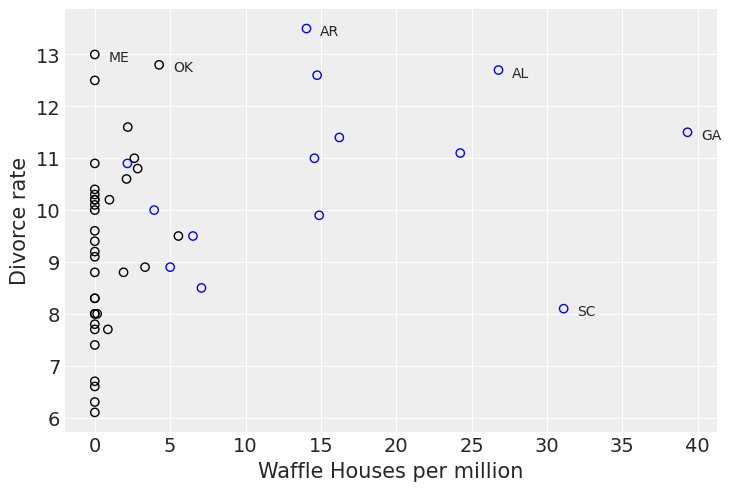

In [10]:
# Fig 5.1, missing mean
fig, ax = plt.subplots()

# assign colours to confederate states
colors = {"1": "blue", "0": "black"}

ax.scatter(
    data["WaffleHouses"] / data["Population"],
    data["Divorce"],
    lw=1,
    color=(0, 0, 0, 0),
    edgecolor=data["South"].apply(lambda x: colors[str(x)]),
)

ax.set_xlabel("Waffle Houses per million")
ax.set_ylabel("Divorce rate")

# take only the states with Divorce rate over 12.6 or number of Waffle houses per million inhabitants over 30
selection = data[(data["Divorce"] > 12.6) | (data["WaffleHouses"] / data["Population"] > 30)]

# label those points
for state, div, ratio in zip(
    selection["Loc"],
    selection["WaffleHouses"] / selection["Population"],
    selection["Divorce"],
):
    ax.annotate(f"{state}", xy=(div, ratio), textcoords="offset points", xytext=(10, -5))
    

Text(0.5, 0, 'Median age marriage')

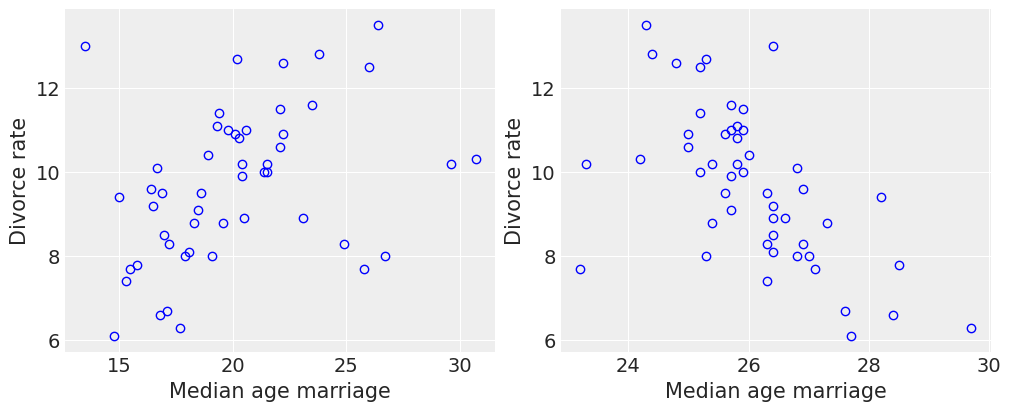

In [11]:
# Fig 5.2, missing mean and CI
fid, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(data["Marriage"], data["Divorce"], lw=1, color=(0, 0, 0, 0), edgecolor="b")
ax[0].set_ylabel("Divorce rate")
ax[0].set_xlabel("Median age marriage")

ax[1].scatter(data["MedianAgeMarriage"], data["Divorce"], lw=1, color=(0, 0, 0, 0), edgecolor="b")
ax[1].set_ylabel("Divorce rate")
ax[1].set_xlabel("Median age marriage")

## Code 5.1

In [12]:
data_std = (data
             .assign(
                 Divorce_std = lambda x: stats.zscore(x['Divorce']),
                 Marriage_std = lambda x: stats.zscore(x['Marriage']),
                 MedianAgeMarriage_std = lambda x: stats.zscore(x['MedianAgeMarriage'])            
             )
    
)

## Code 5.2

In [13]:
with pm.Model() as m_5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bA * data_std["MedianAgeMarriage_std"].values)

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data_std["Divorce_std"].values
    )

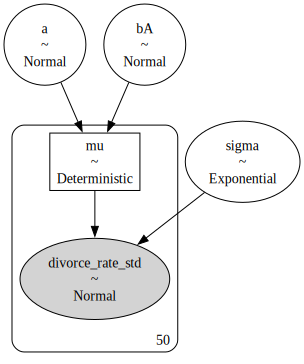

In [14]:
pm.model_to_graphviz(m_5_1)

In [15]:
with m_5_1:
    prior_samples = pm.sample_prior_predictive()

Sampling: [a, bA, divorce_rate_std, sigma]


In [16]:
with m_5_1:
    m_5_1_trace = pm.sample()

C:\Users\bacos1\AppData\Local\anaconda3\envs\per_python_bayes\lib\site-packages\multipledispatch\dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


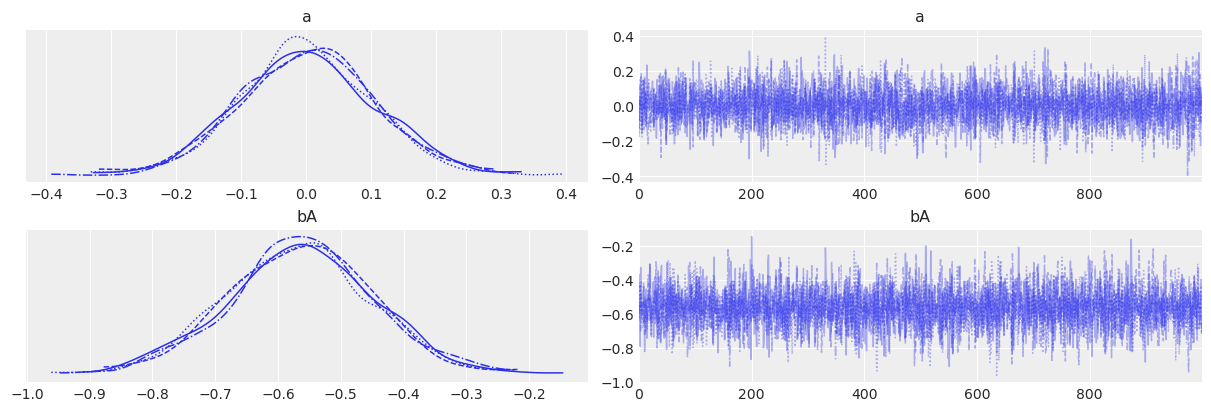

In [17]:
az.plot_trace(m_5_1_trace, var_names = ['a', 'bA']);

## Code 5.4

C:\Users\bacos1\AppData\Local\Temp\ipykernel_27136\2655205262.py:5: FutureWarning: extract_dataset has been deprecated, please use extract
  prior_samp_a = np.array(az.extract_dataset(prior_samples["prior"])["a"][:50])
C:\Users\bacos1\AppData\Local\Temp\ipykernel_27136\2655205262.py:6: FutureWarning: extract_dataset has been deprecated, please use extract
  prior_samp_bA = np.array(az.extract_dataset(prior_samples["prior"])["bA"][:50])


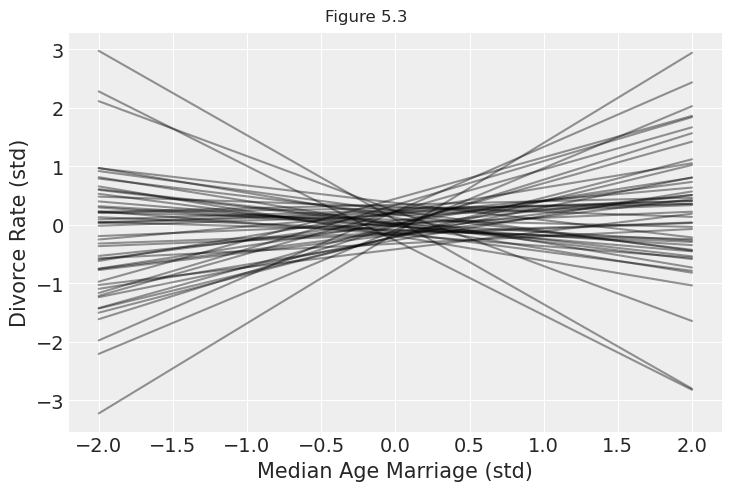

In [19]:
fig, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

prior_samp_a = np.array(az.extract_dataset(prior_samples["prior"])["a"][:50])
prior_samp_bA = np.array(az.extract_dataset(prior_samples["prior"])["bA"][:50])

for a, ba in zip(prior_samp_a, prior_samp_bA):
    y = a + ba * x
    ax.plot(x, y, c="black", alpha=0.4)

ax.set_xlabel("Median Age Marriage (std)")
ax.set_ylabel("Divorce Rate (std)")
fig.suptitle("Figure 5.3");

## Code 5.5

In [20]:
m_5_1_trace.posterior['bA'].shape

(4, 1000)

In [21]:
age_std_seq = np.linspace(-3, 3.3, 30)

In [22]:
m_5_1_data = az.extract(m_5_1_trace.posterior)

m_5_1_data.head()

<xarray.Dataset> Size: 420B
Dimensions:   (sample: 5, mu_dim_0: 5)
Coordinates:
  * mu_dim_0  (mu_dim_0) int32 20B 0 1 2 3 4
  * sample    (sample) object 40B MultiIndex
  * chain     (sample) int32 20B 0 0 0 0 0
  * draw      (sample) int32 20B 0 1 2 3 4
Data variables:
    a         (sample) float64 40B -0.1506 0.05717 0.002694 0.01595 0.174
    bA        (sample) float64 40B -0.4978 -0.3709 -0.792 -0.3282 -0.6193
    sigma     (sample) float64 40B 0.8442 0.8943 0.7799 0.844 0.8433
    mu        (mu_dim_0, sample) float64 200B 0.1542 0.2843 ... -0.1829 -0.2013
Attributes:
    created_at:                 2025-02-04T12:22:03.004409
    arviz_version:              0.17.1
    inference_library:          pymc
    inference_library_version:  5.12.0
    sampling_time:              30.52133584022522
    tuning_steps:               1000

In [23]:
mu_pred = np.zeros((len(age_std_seq), len(m_5_1_data.sample)))

In [25]:
for i, age_std in enumerate(age_std_seq):
    mu_pred[i] = m_5_1_data['a'] + m_5_1_data['bA'] * age_std

In [26]:
mu_pred

array([[ 1.34263131,  1.16984267,  2.37881032, ...,  1.22971312,
         1.25618199,  1.25985017],
       [ 1.2344987 ,  1.08926999,  2.20674672, ...,  1.12387062,
         1.1713761 ,  1.16123784],
       [ 1.12636608,  1.00869731,  2.03468312, ...,  1.01802812,
         1.08657021,  1.06262552],
       ...,
       [-1.57694937, -1.00561964, -2.26690692, ..., -1.6280343 ,
        -1.03357702, -1.40268272],
       [-1.68508199, -1.08619232, -2.43897052, ..., -1.7338768 ,
        -1.11838291, -1.50129505],
       [-1.79321461, -1.16676499, -2.61103412, ..., -1.8397193 ,
        -1.2031888 , -1.59990738]])

In [27]:
mu_mean = mu_pred.mean(axis = 1)

In [28]:
mu_mean

array([ 1.69663807,  1.57388327,  1.45112846,  1.32837365,  1.20561884,
        1.08286403,  0.96010923,  0.83735442,  0.71459961,  0.5918448 ,
        0.46908999,  0.34633518,  0.22358038,  0.10082557, -0.02192924,
       -0.14468405, -0.26743886, -0.39019366, -0.51294847, -0.63570328,
       -0.75845809, -0.8812129 , -1.0039677 , -1.12672251, -1.24947732,
       -1.37223213, -1.49498694, -1.61774174, -1.74049655, -1.86325136])

C:\Users\bacos1\AppData\Local\anaconda3\envs\per_python_bayes\lib\site-packages\arviz\plots\hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


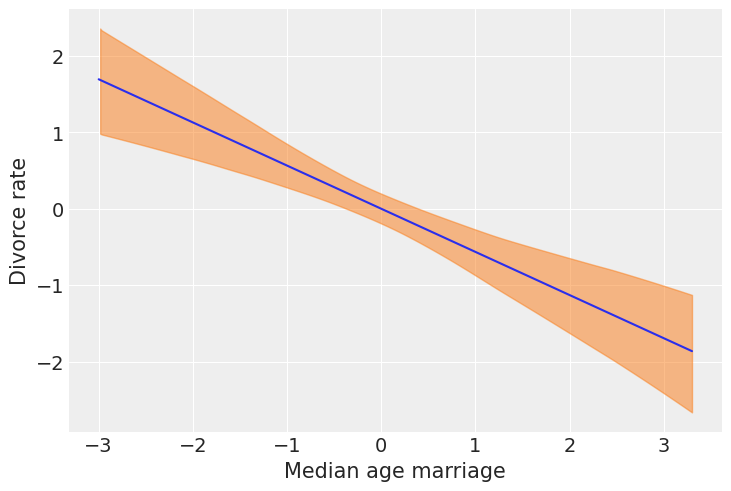

In [29]:
# This is equivalent of Percent Interval
ax = az.plot_hdi(age_std_seq, mu_pred.T)
plt.plot(age_std_seq, mu_mean)
ax.set_xlabel("Median age marriage")
ax.set_ylabel("Divorce rate");

## 5.6 

In [30]:
with pm.Model() as m_5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bM * data_std["Marriage_std"].values)

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data_std["Divorce_std"].values
    )

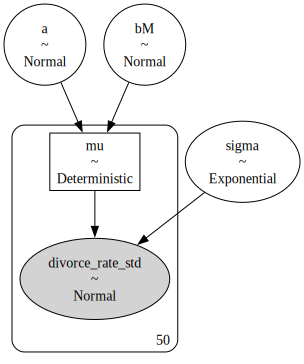

In [31]:
pm.model_to_graphviz(m_5_2)

In [32]:
with m_5_2:
    prior_samples = pm.sample_prior_predictive()

Sampling: [a, bM, divorce_rate_std, sigma]


In [33]:
with m_5_2:
    m_5_2_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


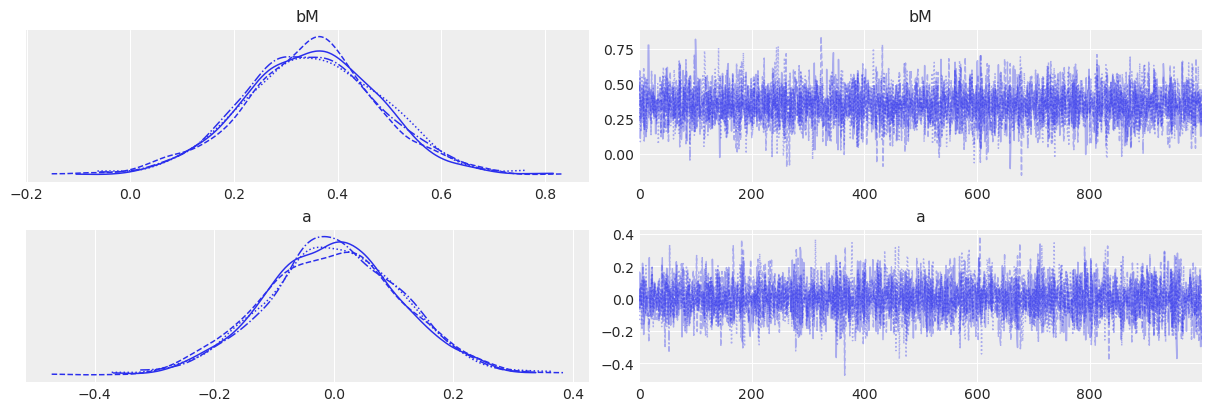

In [34]:
az.plot_trace(m_5_2_trace, var_names=["bM", "a"]);

## 5.7

In [35]:
dag5_1 = CausalGraphicalModel(
    nodes = ['A', 'D', 'M'],
    edges = [('A', 'D'), ('A', 'M'), ('M', 'D')]
)

In [36]:
pgm = daft.PGM()

In [37]:
coordinates = {'A': (0,0), 'D': (1,1), 'M': (2,0)}

In [38]:
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)

C:\Users\bacos1\AppData\Local\anaconda3\envs\per_python_bayes\lib\site-packages\IPython\core\events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
C:\Users\bacos1\AppData\Local\anaconda3\envs\per_python_bayes\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


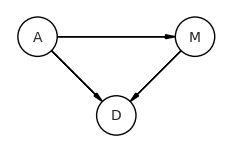

In [39]:
pgm.render()
plt.gca().invert_yaxis()

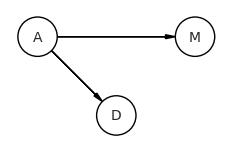

In [40]:
# Note - There is no explicit code section for drawing the second DAG
# but the figure appears in the book and hence drawing it as well
dag5_2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_2.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_2.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

In [41]:
print(dag5_2.get_distribution())

P(A)P(D|A)P(M|A)


In [42]:
dag5_2.get_all_independence_relationships()

[('D', 'M', {'A'})]

In [43]:
DMA_dag2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
all_independencies = DMA_dag2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('D', 'M', {'A'})


In [44]:
DMA_dag1 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")])
all_independencies = DMA_dag1.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

## 5.10

In [45]:
with pm.Model() as m_5_3:

    # Priors
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    sigma = pm.Exponential('sigma', 1)

    # Model
    mu = pm.Deterministic(
        "mu", 
        a + bM * data_std["Marriage_std"].values + bA * data_std["MedianAgeMarriage_std"].values
    )

    # Likelihood
    divorce_rate_std = pm.Normal(
        "divorce_rate_std", 
         mu = mu, 
         sigma = sigma, 
         observed = data_std["Divorce_std"].values
    )

In [46]:
with m_5_3:
    prior_samples = pm.sample_prior_predictive()

Sampling: [a, bA, bM, divorce_rate_std, sigma]


In [47]:
with m_5_3:
     m_5_3_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


In [48]:
az.summary(m_5_3_trace, var_names=["a", "bM", "bA", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.001,0.100,-0.183,0.191,0.002,0.001,3511.0,3021.0,1.0
bM,-0.061,0.161,-0.382,0.226,0.003,0.002,2573.0,2865.0,1.0
bA,-0.609,0.162,-0.903,-0.293,0.003,0.002,2768.0,2287.0,1.0
sigma,0.833,0.085,0.680,0.998,0.001,0.001,3656.0,2863.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

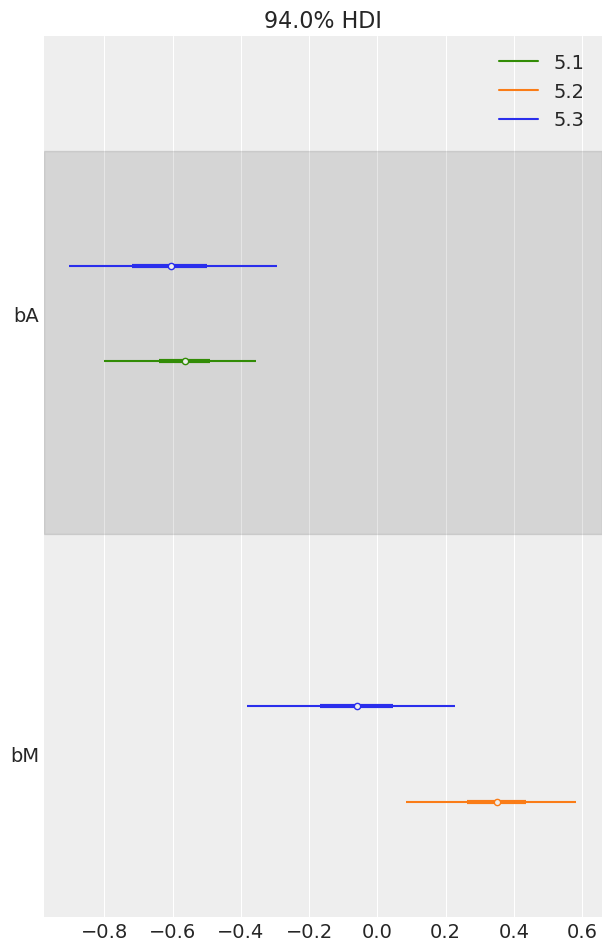

In [49]:
az.plot_forest(
    [
        m_5_3_trace,
        m_5_2_trace,
        m_5_1_trace,
    ],
    model_names=["5.3", "5.2", "5.1"],
    var_names=["bA", "bM"],
    combined=True,
)

## 5.12

In [50]:
N = 50

In [51]:
age = stats.norm().rvs(N)

In [52]:
mar = stats.norm(-age).rvs(N)

In [53]:
div = stats.norm(age).rvs(N)

## 5.13

In [54]:
with pm.Model() as m_5_4:
    a = pm.Normal("a", 0, 0.2)
    bAM = pm.Normal("bAM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)

    mu = pm.Deterministic("mu", a + bAM * data_std["MedianAgeMarriage_std"].values)

    marriage_std = pm.Normal(
        "Marriage_std", mu=mu, sigma=sigma, observed=data_std["Marriage_std"].values
    )

In [55]:
with m_5_4:
    prior_samples = pm.sample_prior_predictive()

Sampling: [Marriage_std, a, bAM, sigma]


In [56]:
with m_5_4:
     m_5_4_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bAM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


## 5.14

In [57]:
mu_m_5_4_mean = m_5_4_trace.posterior["mu"].mean(dim=["chain", "draw"])
residuals = data_std["Marriage_std"] - mu_m_5_4_mean

# 5.15

In [58]:
with m_5_3:
    m_5_3_ppc = pm.sample_posterior_predictive(
        m_5_3_trace,
        var_names = ['mu', 'divorce_rate_std']
    )

Sampling: [divorce_rate_std]


In [59]:
mu_mean = (m_5_3_ppc
           .posterior_predictive['mu']
           .mean(dim = ['chain', 'draw'])
)

In [60]:
mu_PI = az.hdi(m_5_3_ppc.posterior_predictive['mu'], 0.89)

In [61]:
D_sim = (m_5_3_ppc
         .posterior_predictive['divorce_rate_std']
         .mean(dim = ['chain', 'draw'])
)

In [62]:
D_PI = az.hdi(m_5_3_ppc.posterior_predictive['divorce_rate_std'], 0.89)

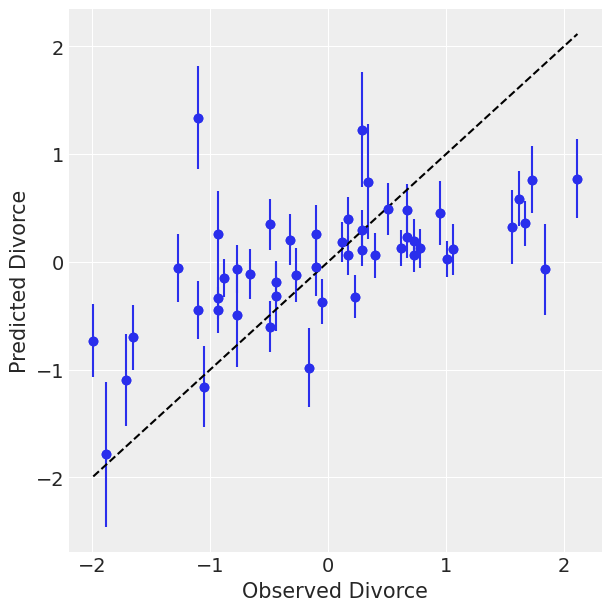

In [63]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.errorbar(
    data_std["Divorce_std"].values,
    D_sim,
    yerr=np.abs(np.array(D_sim) - mu_PI.min(dim="hdi").to_array()),
    fmt="C0o",
)
ax.scatter(data_std["Divorce_std"].values, D_sim)

min_x, max_x = data_std["Divorce_std"].min(), data_std["Divorce_std"].max()
ax.plot([min_x, max_x], [min_x, max_x], "k--")

ax.set_ylabel("Predicted Divorce")
ax.set_xlabel("Observed Divorce");

## 5.19

In [69]:
marriage_shared = shared(data_std['Marriage_std'].values)

In [70]:
age_shared = shared(data_std['MedianAgeMarriage_std'].values)

In [74]:
with pm.Model() as m5_3_A:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bA * age_shared + bM * marriage_shared)
    divorce = pm.Normal("divorce", mu, sigma, observed=data_std["Divorce_std"].values) 

    # A -> M
    sigma_M = pm.Exponential("sigma_m", 1)
    bAM = pm.Normal("bAM", 0, 0.5)
    aM = pm.Normal("aM", 0, 0.2)
    mu_M = pm.Deterministic("mu_m", aM + bAM * age_shared)
    marriage = pm.Normal("marriage", mu_M, sigma_M, observed=data_std["Marriage_std"].values)

In [75]:
with m5_3_A:
    m5_3_A_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, bM, a, sigma_m, bAM, aM]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


In [78]:
az.summary(m5_3_A_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bA,-0.608,0.156,-0.909,-0.326,0.002,0.002,4291.0,2934.0,1.0
bM,-0.060,0.154,-0.358,0.217,0.002,0.002,4241.0,2979.0,1.0
a,0.000,0.102,-0.197,0.184,0.001,0.002,5526.0,3107.0,1.0
bAM,-0.691,0.097,-0.878,-0.518,0.001,0.001,4661.0,2872.0,1.0
aM,0.001,0.090,-0.166,0.176,0.001,0.002,5384.0,2778.0,1.0
...,...,...,...,...,...,...,...,...,...
mu_m[45],-0.193,0.095,-0.366,-0.007,0.001,0.001,5230.0,2885.0,1.0
mu_m[46],0.087,0.091,-0.085,0.255,0.001,0.001,5367.0,2782.0,1.0
mu_m[47],0.593,0.122,0.362,0.817,0.002,0.001,5354.0,3302.0,1.0
mu_m[48],-0.137,0.093,-0.313,0.040,0.001,0.001,5267.0,2782.0,1.0


## 5.20

In [79]:
A_seq = np.linspace(-2, 2, 50)
A_seq.shape

(50,)

## 5.21

In [82]:
# The same variable was updated for the new values
age_shared.set_value(A_seq)

In [83]:
with m5_3_A:
    m5_3_M_marriage = pm.sample_posterior_predictive(m5_3_A_trace)

Sampling: [divorce, marriage]


## 5.22

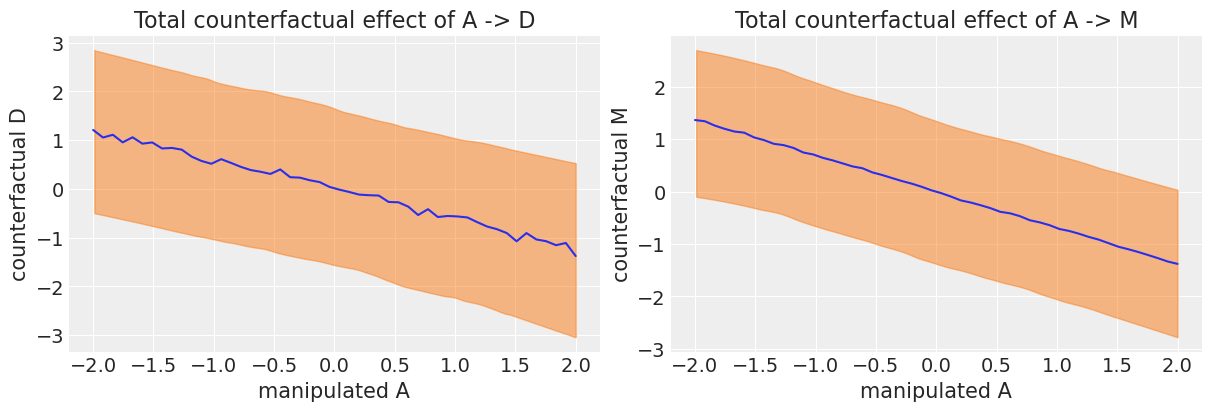

In [85]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
az.plot_hdi(A_seq, m5_3_M_marriage.posterior_predictive["divorce"], ax=ax[0])
ax[0].plot(A_seq, m5_3_M_marriage.posterior_predictive["divorce"].mean(dim=["chain", "draw"]))
ax[0].set_title("Total counterfactual effect of A -> D")
ax[0].set_xlabel("manipulated A")
ax[0].set_ylabel("counterfactual D")

az.plot_hdi(A_seq, m5_3_M_marriage.posterior_predictive["marriage"], ax=ax[1])
ax[1].plot(A_seq, m5_3_M_marriage.posterior_predictive["marriage"].mean(dim=["chain", "draw"]))
ax[1].set_title("Total counterfactual effect of A -> M")
ax[1].set_xlabel("manipulated A")
ax[1].set_ylabel("counterfactual M");

## 5.23

In [90]:
A_seq = (np.linspace(20, 30, 50) - 26.1) / 1.24

In [91]:
age_shared.set_value(A_seq)

In [92]:
with m5_3_A:
    m5_3_M_ppc = pm.sample_posterior_predictive(m5_3_A_trace)

Sampling: [divorce, marriage]


In [93]:
# Average first and last column and take difference
(
    m5_3_M_ppc.posterior_predictive["divorce"][:, -1].mean()
    - m5_3_M_ppc.posterior_predictive["divorce"][:, 0].mean()
)

<xarray.DataArray 'divorce' ()> Size: 8B
array(0.12972265)

# 5.24

In [94]:
# Set values for marriage counterfactual
marriage_counter_factual_x = np.linspace(-2, 2, 50)
marriage_shared.set_value(marriage_counter_factual_x)

# Fix age to zero
age_shared.set_value(np.zeros(50))

with m5_3_A:
    m5_3_M_ppc = pm.sample_posterior_predictive(m5_3_A_trace)

Sampling: [divorce, marriage]


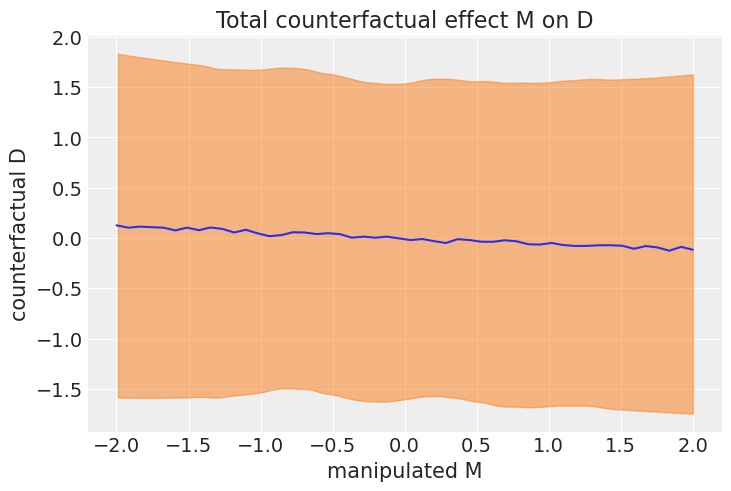

In [95]:

fig, ax = plt.subplots()

az.plot_hdi(marriage_counter_factual_x, m5_3_M_ppc.posterior_predictive["divorce"], ax=ax)
ax.plot(
    marriage_counter_factual_x,
    m5_3_M_ppc.posterior_predictive["divorce"].mean(dim=["chain", "draw"]),
)
ax.set_title("Total counterfactual effect M on D")
ax.set_xlabel("manipulated M")
ax.set_ylabel("counterfactual D");

## 5.25 

In [96]:
A_seq = np.linspace(-2, 2, 30)

# 5.26

In [97]:
# Get the samples from Age Marriage model first
with m5_3_A:
    m5_3_M_marriage = pm.sample_posterior_predictive(
        m5_3_A_trace, var_names=["sigma_m", "aM", "bAM"]
    )

Sampling: [aM, bAM, sigma_m]


In [98]:
marriage_mu_counterfactual = np.outer(
    m5_3_M_marriage.posterior_predictive["aM"] + m5_3_M_marriage.posterior_predictive["bAM"], A_seq
)
marriage_mu_counterfactual.shape

(4000, 30)

In [100]:
mu = marriage_mu_counterfactual.T
sigma = az.extract(m5_3_M_marriage.posterior_predictive["sigma_m"]).to_array()
M_sim = stats.norm(loc=mu, scale=sigma).rvs()
M_sim.shape

(30, 4000)

## 5.28

In [112]:
d = pd.read_csv(
     'C:/Users/bacos1/Documents/Python/per_python_bayes/Statistical_Rethinking/data/milk.csv',
    delimiter = ';'
)

In [113]:
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [128]:
dcc = (d
     .dropna(axis = 0)
     .assign(
         K = lambda x: stats.zscore(x['kcal.per.g']),
         N = lambda x: stats.zscore(x['neocortex.perc']),
         M = lambda x: stats.zscore(x['mass']),
     )
    
)

In [129]:
dcc.shape

(17, 11)

In [134]:
shared_N = shared(dcc['N'].values)

In [135]:
# This is meant to fail!
with pm.Model() as m5_5_draft:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 1)
    a = pm.Normal("a", 0, 1)
    mu = pm.Deterministic("mu", a + bN * shared_N)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

In [136]:
with m5_5_draft:
    m5_5_draft_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


## 5.33

In [137]:
xseq = [-2, 2]
shared_N.set_value(np.array(xseq))

In [138]:
with m5_5_draft:
    m5_5_draft_prior_predictive = pm.sample_prior_predictive()

Sampling: [K, a, bN, sigma]


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (17,) and arg 1 with shape (2,).
Apply node that caused the error: normal_rv{0, (0, 0), floatX, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x1CAF79BAF20>), [17], 11, mu, sigma)
Toposort index: 6
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(1,)), TensorType(int64, shape=()), TensorType(float64, shape=(None,)), TensorType(float64, shape=())]
Inputs shapes: ['No shapes', (1,), (), (2,), ()]
Inputs strides: ['No strides', (8,), (), (8,), ()]
Inputs values: [Generator(PCG64) at 0x1CAF79BAF20, array([17], dtype=int64), array(11, dtype=int64), array([ 0.88906932, -2.59991788]), array(1.81525876)]
Outputs clients: [['output'], ['output']]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [139]:
shared_N = shared(dcc["N"].values)

with pm.Model() as m5_5:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bN * shared_N)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

In [140]:
with m5_5:
      m5_5_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


In [142]:
m5_5_data = az.extract(m5_5_trace)

In [144]:
az.summary(m5_5_trace, var_names=["a", "bN", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.158,-0.297,0.287,0.002,0.002,4498.0,2941.0,1.0
bN,0.123,0.225,-0.316,0.528,0.003,0.003,5312.0,2850.0,1.0
sigma,1.061,0.193,0.740,1.428,0.003,0.002,4750.0,2984.0,1.0


Sampling: []


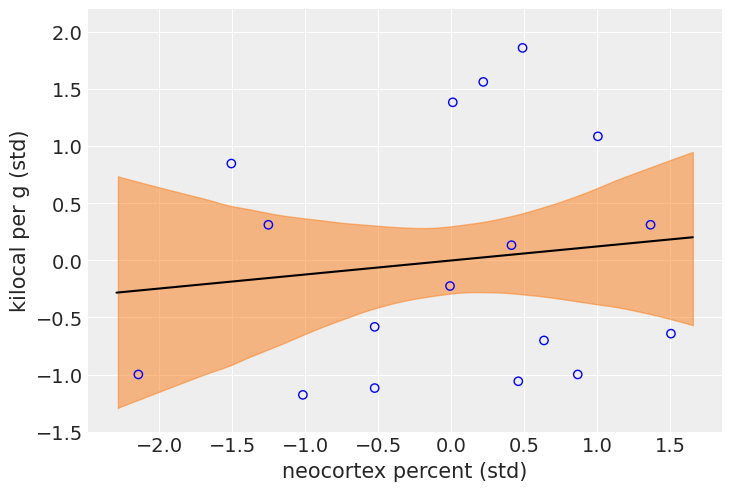

In [145]:
xseq = np.linspace(dcc["N"].min() - 0.15, dcc["N"].max() + 0.15, 30)

shared_N.set_value(xseq)

with m5_5:
    m5_5_posterior_predictive = pm.sample_posterior_predictive(m5_5_trace, var_names=["mu"])

mu_ppd = m5_5_posterior_predictive.posterior_predictive["mu"]
mu_mean = mu_ppd.mean(dim=["chain", "draw"])

fig, ax = plt.subplots()
az.plot_hdi(xseq, mu_ppd, ax=ax)
ax.plot(xseq, mu_mean, c="black")
ax.scatter(dcc["N"], dcc["K"], facecolors="none", edgecolors="b")
ax.set_ylim(-1.5, 2.2)
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

## 5.38

In [147]:
shared_N = shared(dcc["N"].values)
shared_M = shared(dcc["M"].values)

In [148]:
with pm.Model() as m5_7:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)

    mu = pm.Deterministic("mu", a + bN * shared_N + bM * shared_M)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

In [149]:
with m5_7:
    m5_7_trace = pm.sample(tune=2000, draws=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, bM, a]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 50 seconds.


In [150]:
m5_7_data = az.extract(m5_7_trace)

In [152]:
az.summary(m5_7_trace, var_names=["a", "bN", "bM", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.000,0.149,-0.270,0.291,0.001,0.001,35171.0,30361.0,1.0
bN,0.384,0.246,-0.075,0.852,0.002,0.001,24956.0,25794.0,1.0
bM,-0.496,0.248,-0.942,-0.008,0.002,0.001,23851.0,24737.0,1.0
sigma,0.928,0.182,0.620,1.266,0.001,0.001,29907.0,26801.0,1.0


In [153]:
az.plot_forest(
    [m5_7_trace, m5_6_trace, m5_5_trace],
    model_names=["m5.7", "m5.6", "m5.5"],
    var_names=["bM", "bN"],
    combined=True,
);

NameError: name 'm5_6_trace' is not defined